In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../..')

In [2]:
import os
import pandas as pd
from src.utils.preprocess import preprocess_video, split_video, split_audio
import librosa
from datetime import datetime
from src.utils.model import get_audio_model, get_visual_model, find_ckpt
from src.utils.transforms import get_video_transforms
from src.utils.engine import yaml_search, get_recording_filename, read_frames, get_recording_paths, predict, \
    predict_with_files

In [3]:
from moviepy.video.io.VideoFileClip import VideoFileClip


def cvt_25fps(input_file, output_file):
    # Load the video clip
    clip = VideoFileClip(input_file)
    # Set the target frame rate to 25 FPS
    target_fps = 25
    # Convert the clip to 25 FPS
    clip_25fps = clip.set_fps(target_fps)
    # Write the converted clip to a new file
    clip_25fps.write_videofile(output_file, codec="libx264")
    # Close the clip
    clip.close()


def extract_audio(input_file, output_file):
    # Load the video clip
    clip = VideoFileClip(input_file)
    # Extract the audio from the video
    audio = clip.audio
    # Save the audio as a WAV file
    audio.write_audiofile(output_file, codec="pcm_s16le")
    # Close the clip
    clip.close()

In [4]:
from pathlib import Path

person = "unpas"
base_dir = f"../resources/data/YouTube/{person}"
cut_dir = f"{base_dir}/cut"
pred_dir = f"{base_dir}/prediction"
processed_dir = f"{base_dir}/processed"
result_dir = f"{base_dir}/results"
Path(processed_dir).mkdir(parents=True, exist_ok=True)
Path(pred_dir).mkdir(parents=True, exist_ok=True)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for file in os.listdir(cut_dir):
    basename = file.split(".")[0]
    cvt_25fps(
        input_file=f"{cut_dir}/{basename}.mp4",
        output_file=f"{processed_dir}/{basename}.mp4"
    )
    extract_audio(
        input_file=f"{cut_dir}/{basename}.mp4",
        output_file=f"{processed_dir}/{basename}.wav"
    )

In [7]:
videos = []
audios = []
unique = []
for file in os.listdir(processed_dir):
    # Load Video & Audio
    basename = file.split(".")[0]
    if basename in unique: continue
    ori_video, (w, h) = read_frames(f"{processed_dir}/{basename}.mp4")
    ori_audio, _ = librosa.load(f"{processed_dir}/{basename}.wav", sr=16000)
    videos.append(ori_video)
    audios.append(ori_audio)
    unique.append(basename)

47
56
33
60
84
64
81
94
80
62


In [ ]:
len(videos)

In [8]:
def generate_filenames():
    # Filenames for Target
    dt = datetime.now()
    time = int(dt.strftime("%Y%m%d%H%M%S"))
    filepath = f"{cwd}/results"
    filename = f"{time}"
    filename_prediction = f"{filename}_Prediction.MP4"
    filepath_prediction = f"{filepath}/{filename_prediction}"
    filename_latent = f"{filename}_Latent.MP4"
    filepath_latent = f"{filepath}/{filename_latent}"
    filename_ori = f"{filename}_Original.MP4"
    filepath_ori = f"{filepath}/{filename_ori}"
    return filepath_prediction, filepath_latent, filepath_ori

In [9]:
from torchmetrics.functional.audio.stoi import short_time_objective_intelligibility
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from tqdm import tqdm

In [10]:
def print_metric(pesq, stoi, estoi):
    print("------------------")
    print("PESQ:", pesq)
    print("STOI:", stoi)
    print("ESTOI:", estoi)
    print("------------------")

In [11]:
import torch
import numpy as np
import soundfile as sf

def sew_audios(wavs):
    audio_data = []

    for wav in wavs:
        audio_data.append(wav)

    # Concatenate the audio data
    concatenated_data = np.concatenate(audio_data)
    return concatenated_data

def cut_ori_audio(ori_audio, total_frames, sr=16000, fps=25):
    frame = sr//fps
    print(int(total_frames*frame))
    return ori_audio[:int(total_frames*frame)]

def prep_audio(modified_audio, target_length):
    # Adjust the length of the resampled modified audio to match the target length
    if len(modified_audio) > target_length:
        modified_audio = modified_audio[:target_length]
    elif len(modified_audio) < target_length:
        modified_audio = librosa.util.fix_length(modified_audio, size=target_length)

    return modified_audio

In [12]:
def load_model(model, cwd, _type, frames, run_name):
    default_ckpt_path = f"{cwd}/models/ilmsg-{_type}/f{frames}"
    ckpt_filename = find_ckpt(f"{default_ckpt_path}/{run_name}/")
    ckpt_path = f"{default_ckpt_path}/{run_name}/{ckpt_filename}"
    model = model.load_from_checkpoint(ckpt_path).cuda()
    return model


def reload_model(cwd, model_conf, data, experiment, learning_rate):
    vmodel = get_visual_model(model_conf["version"], learning_rate, model_conf["name"], experiment)
    amodel = get_audio_model(data["audio_version"], learning_rate, data["audio_run"])
    # Load Audio CKPT
    amodel = load_model(amodel, cwd, "audio", data["frames"], data["audio_run"])
    # Load Video CKPT
    vmodel = load_model(vmodel, cwd, "video", data["frames"], model_conf["name"])
    amodel.eval()
    vmodel.eval()
    return amodel, vmodel

In [13]:
cwd = f"{os.getcwd()}/../../src/resources"
# Pria: 66,68,88,87,90
# Wanita: 106, 107, 109, 110, 108
run_model = 68
experiment = yaml_search(f"{cwd}/experiments/video", run_model)

hparams = experiment["hyperparameters"]
config = experiment["config"]
data = experiment["data"]

seed, batch_size, learning_rate = hparams["seed"], hparams["batch_size"], float(hparams["learning_rate"])
model_conf = experiment["model"]
config = experiment["config"]
data = experiment["data"]
transforms = get_video_transforms(data["transform"], data["color"])
arr_size = [150, 150]

audio_model, visual_model = reload_model(cwd, model_conf, data, experiment, learning_rate)

In [15]:
scores = {}
scores["PESQ"] = []
scores["STOI"] = []
scores["ESTOI"] = []
pred_wavs = []
for i in tqdm(range(len(videos))):
# for i in tqdm(range(1, 2)):
    filepath_prediction, filepath_latent, filepath_ori = generate_filenames()
    ori_video = videos[i]
    ori_audio = audios[i]
    preprocessed_frames = preprocess_video(
        rid=None,
        transforms=transforms,
        frames=ori_video,
        vid_size=arr_size,
        local=False,
        to_gray=True
    )
    # Split Video
    video_batch = split_video(
        frames=preprocessed_frames,
        split_frames=data["frames"],
        stride=data["frames"],
        total_frames=len(preprocessed_frames)
    )
    video_batch = video_batch.cuda()

    pred_audios = []
    pred_latents = []
    pred_mels = []

    for j in range(len(video_batch)):
        video = video_batch[j].unsqueeze(0).cuda()

        (ori_mels, ori_latent, ori_audio), (target_mels, target_latent, target_wav) = predict(
            visual_model=visual_model,
            filepaths=(filepath_prediction, filepath_latent, filepath_ori),
            ori_video=ori_video,
            video_batch=video,
            audio_model=audio_model,
            ori_audio=ori_audio,
            label_batch=None,
            generate_video=False
        )
        pred_audios.append(target_wav)
        pred_latents.append(target_latent)
        pred_mels.append(target_mels)

        # audio_model, visual_model = reload_model(cwd, model_conf, data, experiment, learning_rate)
        del video
        torch.cuda.empty_cache()
    target_wav = sew_audios(pred_audios)
    target_wav = prep_audio(target_wav, len(ori_audio))
    target_wav = torch.from_numpy(target_wav)
    ori_audio = torch.from_numpy(ori_audio)
    sf.write(f"{pred_dir}/{i}_pred.wav", target_wav, samplerate=16000)
    sf.write(f"{pred_dir}/{i}_ori.wav", ori_audio, samplerate=16000)
    pred_wavs.append(target_wav)
    pesq = perceptual_evaluation_speech_quality(target_wav, ori_audio, 16000, "wb")
    stoi = short_time_objective_intelligibility(target_wav, ori_audio, 16000).float()
    estoi = short_time_objective_intelligibility(target_wav, ori_audio, 16000, extended=True).float()
    scores["PESQ"].append(pesq)
    scores["STOI"].append(stoi)
    scores["ESTOI"].append(estoi)
    print_metric(pesq, stoi, estoi)


  0%|          | 0/10 [00:00<?, ?it/s]

<_dlib_pybind11.fhog_object_detector object at 0x7fe0c0311f30> <_dlib_pybind11.shape_predictor object at 0x7fe0c2b07170>
Calculate Centroid



100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


[969.29787234 435.23404255]


 10%|█         | 1/10 [00:20<03:04, 20.50s/it]

------------------
PESQ: tensor(1.0433)
STOI: tensor(0.1789)
ESTOI: tensor(-0.0025)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0b7feba30> <_dlib_pybind11.shape_predictor object at 0x7fe0b605b7b0>
Calculate Centroid



100%|██████████| 56/56 [00:21<00:00,  2.61it/s]


[969.01785714 440.67857143]


 20%|██        | 2/10 [00:44<02:58, 22.30s/it]

------------------
PESQ: tensor(1.2260)
STOI: tensor(0.0373)
ESTOI: tensor(-0.0092)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0b7fd7d70> <_dlib_pybind11.shape_predictor object at 0x7fe0c0375f70>
Calculate Centroid



100%|██████████| 33/33 [00:12<00:00,  2.59it/s]


[971.60606061 449.48484848]


 30%|███       | 3/10 [00:58<02:10, 18.66s/it]

------------------
PESQ: tensor(1.0686)
STOI: tensor(0.1081)
ESTOI: tensor(-0.0903)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0c20f14f0> <_dlib_pybind11.shape_predictor object at 0x7fe0c02b50b0>
Calculate Centroid



100%|██████████| 60/60 [00:23<00:00,  2.59it/s]


[972.2        452.43333333]


 40%|████      | 4/10 [01:24<02:08, 21.45s/it]

------------------
PESQ: tensor(1.0608)
STOI: tensor(0.2459)
ESTOI: tensor(0.1215)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0c0308c70> <_dlib_pybind11.shape_predictor object at 0x7fe0b6074430>
Calculate Centroid



100%|██████████| 84/84 [00:32<00:00,  2.61it/s]


[986.57142857 457.97619048]


 50%|█████     | 5/10 [01:59<02:12, 26.46s/it]

------------------
PESQ: tensor(1.1023)
STOI: tensor(0.0733)
ESTOI: tensor(-0.0619)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0b607f770> <_dlib_pybind11.shape_predictor object at 0x7fe0b607f730>
Calculate Centroid



100%|██████████| 64/64 [00:24<00:00,  2.63it/s]


[949.140625 454.296875]


 60%|██████    | 6/10 [02:26<01:46, 26.69s/it]

------------------
PESQ: tensor(1.1238)
STOI: tensor(0.1428)
ESTOI: tensor(0.0826)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0b2d98870> <_dlib_pybind11.shape_predictor object at 0x7fe0c2111570>
Calculate Centroid



100%|██████████| 81/81 [00:31<00:00,  2.61it/s]


[953.16049383 466.59259259]


 70%|███████   | 7/10 [03:01<01:27, 29.24s/it]

------------------
PESQ: tensor(1.0697)
STOI: tensor(0.0845)
ESTOI: tensor(0.0227)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0b604cbf0> <_dlib_pybind11.shape_predictor object at 0x7fe0b2d64470>
Calculate Centroid



100%|██████████| 94/94 [00:36<00:00,  2.61it/s]


[952.11702128 467.84042553]


 80%|████████  | 8/10 [03:40<01:04, 32.33s/it]

------------------
PESQ: tensor(1.0911)
STOI: tensor(0.0203)
ESTOI: tensor(0.0026)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0c20491b0> <_dlib_pybind11.shape_predictor object at 0x7fe0b6046130>
Calculate Centroid



100%|██████████| 80/80 [00:30<00:00,  2.63it/s]


[952.7   459.125]


 90%|█████████ | 9/10 [04:13<00:32, 32.71s/it]

------------------
PESQ: tensor(1.0716)
STOI: tensor(0.0884)
ESTOI: tensor(0.0097)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7fe0c02c3630> <_dlib_pybind11.shape_predictor object at 0x7fe0c03541f0>
Calculate Centroid



100%|██████████| 62/62 [00:23<00:00,  2.62it/s]


[951.59677419 469.        ]


100%|██████████| 10/10 [04:39<00:00, 27.97s/it]

------------------
PESQ: tensor(1.0984)
STOI: tensor(0.0708)
ESTOI: tensor(0.0130)
------------------


In [16]:
from src.utils.video import combine_video

for i in range(len(audios)):
    ori_audio = audios[i]
    ori_video = videos[i]
    pred_wav = pred_wavs[i]
    combine_video(
        f"{result_dir}/{i}_ori.MP4",
        frames=ori_video,
        audio=ori_audio,
        fps=25,
        sr=16000
    )
    
    combine_video(
        f"{result_dir}/{i}_pred.MP4",
        frames=ori_video,
        audio=pred_wav,
        fps=25,
        sr=16000
    )
    

Moviepy - Building video ../resources/data/YouTube/unpas/results/0_ori.MP4.
MoviePy - Writing audio in 0_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/0_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/0_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/0_pred.MP4.
MoviePy - Writing audio in 0_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/0_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/0_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/1_ori.MP4.
MoviePy - Writing audio in 1_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/1_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/1_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/1_pred.MP4.
MoviePy - Writing audio in 1_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/1_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/1_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/2_ori.MP4.
MoviePy - Writing audio in 2_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/2_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/2_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/2_pred.MP4.
MoviePy - Writing audio in 2_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/2_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/2_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/3_ori.MP4.
MoviePy - Writing audio in 3_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/3_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/3_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/3_pred.MP4.
MoviePy - Writing audio in 3_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/3_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/3_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/4_ori.MP4.
MoviePy - Writing audio in 4_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/4_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/4_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/4_pred.MP4.
MoviePy - Writing audio in 4_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/4_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/4_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/5_ori.MP4.
MoviePy - Writing audio in 5_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/5_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/5_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/5_pred.MP4.
MoviePy - Writing audio in 5_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/5_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/5_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/6_ori.MP4.
MoviePy - Writing audio in 6_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/6_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/6_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/6_pred.MP4.
MoviePy - Writing audio in 6_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/6_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/6_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/7_ori.MP4.
MoviePy - Writing audio in 7_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/7_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/7_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/7_pred.MP4.
MoviePy - Writing audio in 7_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/7_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/7_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/8_ori.MP4.
MoviePy - Writing audio in 8_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/8_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/8_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/8_pred.MP4.
MoviePy - Writing audio in 8_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/8_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/8_pred.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/9_ori.MP4.
MoviePy - Writing audio in 9_oriTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/9_ori.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/9_ori.MP4
Moviepy - Building video ../resources/data/YouTube/unpas/results/9_pred.MP4.
MoviePy - Writing audio in 9_predTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../resources/data/YouTube/unpas/results/9_pred.MP4



Moviepy - Done !
Moviepy - video ready ../resources/data/YouTube/unpas/results/9_pred.MP4


In [18]:
len(ori_audio), len(target_wav)

(113600, 113600)

In [22]:
scores

{'PESQ': [tensor(1.0592),
  tensor(1.0901),
  tensor(1.0300),
  tensor(1.0366),
  tensor(1.0743),
  tensor(1.0878),
  tensor(1.0641),
  tensor(1.1616),
  tensor(1.1943),
  tensor(1.1718)],
 'STOI': [tensor(0.1291),
  tensor(0.1748),
  tensor(0.1780),
  tensor(0.1145),
  tensor(0.1301),
  tensor(0.1604),
  tensor(0.1534),
  tensor(0.1721),
  tensor(0.1395),
  tensor(0.1490)],
 'ESTOI': [tensor(-0.0627),
  tensor(-0.0021),
  tensor(0.0284),
  tensor(-0.0105),
  tensor(0.0050),
  tensor(0.0083),
  tensor(-0.0149),
  tensor(0.0417),
  tensor(-0.0080),
  tensor(-0.0195)]}

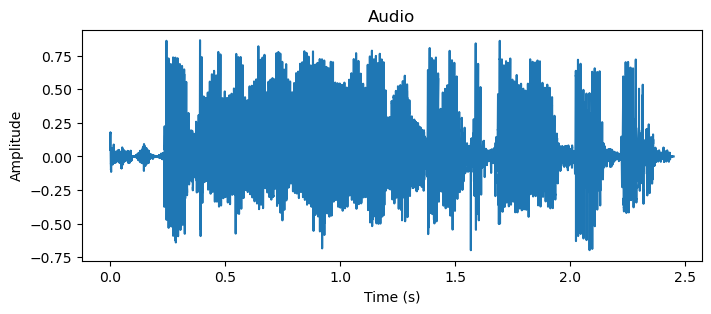

In [17]:
from src.visualization.audio import visualize_audio

visualize_audio(ori_audio)

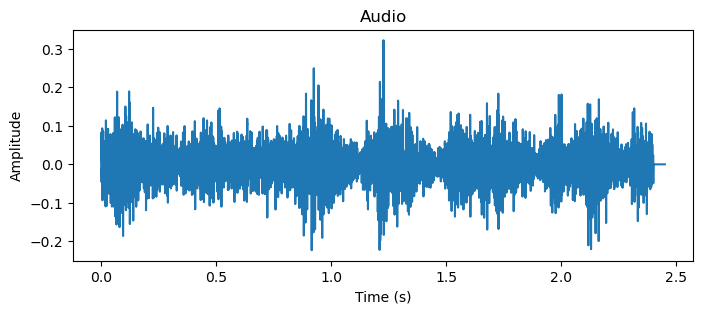

In [18]:
visualize_audio(target_wav)

In [21]:
ori_audio.shape

(131680,)

In [20]:
target_wav.shape

(128000,)